# Inception Model 🤗

# Crop Health Analysis Using NDVI
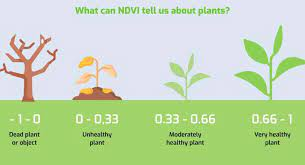


# Objective:
Develop an Web Application AI-powered system to automate crop health monitoring using satellite-derived NDVI (Normalized Difference Vegetation Index) values Classifying The Data into 4 Categories Based on the NDVI Values
Non-Plant[-1:0], Unhealthy[0:0.33],
Moderate[0.33:0.66], Very Healthy [0.66:1]

Dataset Overview
MODIS Terra MOD13QA Dataset
Spatial Resolution: 250m/pixel
Temporal Resolution: 16-day intervals


# Imports and Configuration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation, Dense, Flatten, Dropout, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
from keras import config
from tensorflow.keras.models import load_model
import seaborn as sns


In [ ]:
# Configurable parameters
VEGETATION_THRESHOLD = 0.15
KERNEL_SIZE = 5
TARGET_SIZE = 299  # Changed to 299x299 for InceptionV3
# Modified class thresholds
CLASS_THRESHOLDS = [0, 0.33, 0.66, 1.01]  # thresholds
CLASS_NAMES = ['Non-Plant', 'Unhealthy', 'Moderate', 'Healthy']
N_CLASSES = len(CLASS_NAMES)
BATCH_SIZE = 32
EPOCHS = 20

# Data Loading Function

In [ ]:
def load_and_validate_ndvi(folder_path):
    """Load and validate NDVI data from .npy files with resizing to 299x299"""
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Folder '{folder_path}' does not exist")

    npy_files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
    if not npy_files:
        raise ValueError("No .npy files found in directory")

    chunks = []
    for npy_file in npy_files:
        try:
            chunk = np.load(os.path.join(folder_path, npy_file), allow_pickle=True)
            if not isinstance(chunk, np.ndarray):
                print(f"Warning: {npy_file} is not a numpy array, skipping")
                continue

            # Resize to target size (299x299)
            chunk = cv2.resize(chunk, (TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_LINEAR)
            chunks.append(chunk)
        except Exception as e:
            print(f"Error loading {npy_file}: {e}")
            continue

    if not chunks:
        raise ValueError("No valid NDVI data loaded")

    return np.array(chunks)

# Load Train and Test Data

In [ ]:
# Load training data
train_folder = '/content/drive/MyDrive/Sprints Final Project/Dataset Split/1'

try:
    train_chunks = load_and_validate_ndvi(train_folder)
    print(f"Successfully loaded {len(train_chunks)} train NDVI arrays")
    print("-"*60)
    print(f"Sample train shape: {train_chunks[0].shape}")
except Exception as e:
    print(f"Error: {str(e)}")

Successfully loaded 827 train NDVI arrays
------------------------------------------------------------
Sample train shape: (299, 299)


In [ ]:
from tensorflow.keras.layers import Layer

class NaNHandler(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        return tf.where(inputs == -2, 0.0, inputs)

    def get_config(self):
        return super().get_config()

# Preprocessing and Classification Functions

In [ ]:
def preprocess_ndvi(ndvi_array):
    """Apply preprocessing pipeline to NDVI data with NaN handling."""
    # Create mask before any processing
    nan_mask = np.isnan(ndvi_array)

    # Fill NaNs with 0 temporarily for processing
    processed = np.nan_to_num(ndvi_array, nan=0)

    # Apply processing
    smoothed = cv2.GaussianBlur(processed, (5,5), 0)

    # Re-apply original NaN mask
    smoothed[nan_mask] = np.nan

    # Morphological operations only on valid pixels
    veg_mask = (smoothed > VEGETATION_THRESHOLD).astype(np.uint8)
    kernel = np.ones((KERNEL_SIZE, KERNEL_SIZE), np.uint8)
    veg_mask = cv2.morphologyEx(veg_mask, cv2.MORPH_CLOSE, kernel)
    veg_mask = cv2.morphologyEx(veg_mask, cv2.MORPH_OPEN, kernel)

    return smoothed, veg_mask

In [ ]:
def classify_ndvi(smoothed_ndvi):
    """Classify NDVI values into health categories with NaN awareness."""
    classified = np.full_like(smoothed_ndvi, -1)  # -1 for unclassified
    valid_mask = ~np.isnan(smoothed_ndvi)

    # Classification logic based on thresholds
    for class_idx in range(N_CLASSES):
        lower = CLASS_THRESHOLDS[class_idx]
        upper = CLASS_THRESHOLDS[class_idx+1] if class_idx < N_CLASSES-1 else np.inf
        mask = valid_mask & (smoothed_ndvi >= lower) & (smoothed_ndvi < upper)
        classified[mask] = class_idx

    return classified

# Data Preparation

In [ ]:
def prepare_data(chunks):
    X = []
    y = []

    for chunk in chunks:
        # Compute the mean of valid pixels
        valid_mean = np.nanmean(chunk)

        # Fill NaNs with mean of valid pixels
        filled = np.where(np.isnan(chunk), valid_mean, chunk)

        # Maintain original range [-1, 1]
        filled = np.clip(filled, -1, 1)

        # Apply smoothing
        smoothed = cv2.GaussianBlur(filled, (5,5), 0)
        # Stack the single channel image to create 3 channels
        img_3ch = np.stack([smoothed]*3, axis=-1)

        X.append(img_3ch)

        # Label calculation using original values
        label = 0 if valid_mean < 0 else \
                1 if valid_mean < 0.33 else \
                2 if valid_mean < 0.66 else 3
        y.append(label)

    return np.array(X), to_categorical(y, num_classes=4)


In [ ]:
# Prepare full training data
X, y = prepare_data(train_chunks)

# Create a validation set from the training data ( 20% for validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

# Model Building

In [ ]:
def build_inception_model(input_shape=(299, 299, 3), num_classes=4):
    """Build InceptionV3 model with custom NaN handling"""
    # Input layer
    input_layer = Input(shape=input_shape)

    # Custom NaN handling layer
    x = NaNHandler()(input_layer)

    # Base InceptionV3 model
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_tensor=input_layer
    )
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
model = build_inception_model()
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 23,905,060 (91.19 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

# Model Training

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(
        '/content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_1.keras',
        verbose=1,
        save_best_only=True
    )
]


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.6333 - loss: 0.8953
Epoch 1: val_loss improved from inf to 0.33309, saving model to /content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_1.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.6377 - loss: 0.8852 - val_accuracy: 0.8614 - val_loss: 0.3331 - learning_rate: 1.0000e-04
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8647 - loss: 0.3601
Epoch 2: val_loss improved from 0.33309 to 0.22409, saving model to /content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_1.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 216ms/step - accuracy: 0.8652 - loss: 0.3586 - val_accuracy: 0.9217 - val_loss: 0.2241 - learning_rate: 1.0000e-04
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8899 - loss: 0.2632
Epoch 3: val_loss improved from 0.22409 to 0.19580, saving model to /content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_1.keras
21/21 ━━━━━━━━━━

# Second Iteration: Using Data from Folder 2 and Loading Previous Weights

In [ ]:
# Set new training folder for second iteration
train_folder = '/content/drive/MyDrive/Sprints Final Project/Dataset Split/2'

try:
    train_chunks = load_and_validate_ndvi(train_folder)
    print(f"Successfully loaded {len(train_chunks)} train NDVI arrays from folder 2")
    print(f"Sample train shape: {train_chunks[0].shape}")
except Exception as e:
    print(f"Error: {str(e)}")

Successfully loaded 841 train NDVI arrays from folder 2
Sample train shape: (299, 299)


In [ ]:
# Prepare training data
X_new, y_new = prepare_data(train_chunks)
# Split the training data into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(X_new, y_new, test_size=0.20, random_state=42)

In [ ]:
# Build the model architecture
model = build_inception_model()


In [ ]:
# Load previous weights from the first iteration
model.load_weights('/content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_1.keras')

In [ ]:
# Define callbacks with a new checkpoint path for this iteration
callbacks = [
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(
        '/content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_2.keras',
        verbose=1,
        save_best_only=True
    )
]

In [ ]:
# Train the model on the new training data
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9004 - loss: 0.2650
Epoch 1: val_loss improved from inf to 0.28137, saving model to /content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_2.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9008 - loss: 0.2639 - val_accuracy: 0.9349 - val_loss: 0.2814 - learning_rate: 1.0000e-04
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9348 - loss: 0.1932
Epoch 2: val_loss did not improve from 0.28137
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9348 - loss: 0.1936 - val_accuracy: 0.9290 - val_loss: 0.2862 - learning_rate: 1.0000e-04
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9444 - loss: 0.1592
Epoch 3: val_loss improved from 0.28137 to 0.27577, saving model to /content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_2.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - accuracy: 0.9448 - loss: 0.1589 - val_accuracy: 0.9290 - val_loss: 0.2758 

#Third  Iteration: Using Data from Folder 3 and Loading Previous Weights

In [ ]:
# Set new training folder for second iteration
train_folder = '/content/drive/MyDrive/Sprints Final Project/Dataset Split/3'

try:
    train_chunks = load_and_validate_ndvi(train_folder)
    print(f"Successfully loaded {len(train_chunks)} train NDVI arrays from folder 3")
    print(f"Sample train shape: {train_chunks[0].shape}")
except Exception as e:
    print(f"Error: {str(e)}")

Successfully loaded 820 train NDVI arrays from folder 3
Sample train shape: (299, 299)


In [ ]:
# Prepare training data
X_new_3, y_new_3 = prepare_data(train_chunks)
# Split the training data into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(X_new_3, y_new_3, test_size=0.20, random_state=42)

In [ ]:
# Build the model architecture
model = build_inception_model()


In [ ]:
# Load previous weights from the second iteration
model.load_weights('/content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_2.keras')

In [ ]:
# Define callbacks with a new checkpoint path for this iteration
callbacks = [
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(
        '/content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_3.keras',
        verbose=1,
        save_best_only=True
    )
]

In [ ]:
# Train the model on the new training data
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.9639 - loss: 0.1659
Epoch 1: val_loss improved from inf to 0.16228, saving model to /content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_3.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.9635 - loss: 0.1661 - val_accuracy: 0.9512 - val_loss: 0.1623 - learning_rate: 1.0000e-04
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9613 - loss: 0.1280
Epoch 2: val_loss improved from 0.16228 to 0.16083, saving model to /content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_3.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 482ms/step - accuracy: 0.9608 - loss: 0.1285 - val_accuracy: 0.9512 - val_loss: 0.1608 - learning_rate: 1.0000e-04
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9686 - loss: 0.0884
Epoch 3: val_loss did not improve from 0.16083
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9682 - loss: 0.0895 - val_accuracy: 0.9390 - val_loss: 0.1748

# fourth  Iteration: Using Data from Folder 4 and Loading Previous Weights

In [ ]:
# Set new training folder for second iteration
train_folder = '/content/drive/MyDrive/Sprints Final Project/Dataset Split/4'

try:
    train_chunks = load_and_validate_ndvi(train_folder)
    print(f"Successfully loaded {len(train_chunks)} train NDVI arrays from folder 4")
    print(f"Sample train shape: {train_chunks[0].shape}")
except Exception as e:
    print(f"Error: {str(e)}")

Successfully loaded 783 train NDVI arrays from folder 4
Sample train shape: (299, 299)


In [ ]:
# Prepare training data
X_new_4, y_new_4 = prepare_data(train_chunks)
# Split the training data into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(X_new_4, y_new_4, test_size=0.20, random_state=42)

In [ ]:
# Build the model architecture
model = build_inception_model()

In [ ]:
# Load previous weights from the third iteration
model.load_weights('/content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_3.keras')

In [ ]:
# Define callbacks with a new checkpoint path for this iteration
callbacks = [
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(
        '/content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_4.keras',
        verbose=1,
        save_best_only=True
    )
]

In [ ]:
# Train the model on the new training data
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.9256 - loss: 0.1979
Epoch 1: val_loss improved from inf to 0.18853, saving model to /content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_4.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9257 - loss: 0.1973 - val_accuracy: 0.9172 - val_loss: 0.1885 - learning_rate: 1.0000e-04
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9287 - loss: 0.1646
Epoch 2: val_loss improved from 0.18853 to 0.17474, saving model to /content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_4.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 330ms/step - accuracy: 0.9289 - loss: 0.1644 - val_accuracy: 0.9363 - val_loss: 0.1747 - learning_rate: 1.0000e-04
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9577 - loss: 0.0923
Epoch 3: val_loss improved from 0.17474 to 0.15300, saving model to /content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_4.keras
20/20 ━━━━━━━━━━

# fifth  Iteration: Using Data from Folder 5 and Loading Previous Weights

In [ ]:
# Set new training folder for second iteration
train_folder = '/content/drive/MyDrive/Sprints Final Project/Dataset Split/5'

try:
    train_chunks = load_and_validate_ndvi(train_folder)
    print(f"Successfully loaded {len(train_chunks)} train NDVI arrays from folder 5")
    print(f"Sample train shape: {train_chunks[0].shape}")
except Exception as e:
    print(f"Error: {str(e)}")

Successfully loaded 790 train NDVI arrays from folder 5
Sample train shape: (299, 299)


In [ ]:
# Prepare training data
X_new_5, y_new_5 = prepare_data(train_chunks)
# Split the training data into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(X_new_5, y_new_5, test_size=0.20, random_state=42)

In [ ]:
# Build the model architecture
model = build_inception_model()

In [ ]:
# Load previous weights from the fourth iteration
model.load_weights('/content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_4.keras')

In [ ]:
# Define callbacks with a new checkpoint path for this iteration
callbacks = [
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(
        '/content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_5.keras',
        verbose=1,
        save_best_only=True
    )
]

In [ ]:
# Train the model on the new training data
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.8980 - loss: 0.2422
Epoch 1: val_loss improved from inf to 0.26079, saving model to /content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_5.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8977 - loss: 0.2420 - val_accuracy: 0.8797 - val_loss: 0.2608 - learning_rate: 1.0000e-04
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9173 - loss: 0.2129
Epoch 2: val_loss did not improve from 0.26079
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 151ms/step - accuracy: 0.9175 - loss: 0.2122 - val_accuracy: 0.8924 - val_loss: 0.2648 - learning_rate: 1.0000e-04
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9419 - loss: 0.1630
Epoch 3: val_loss did not improve from 0.26079
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.9419 - loss: 0.1632 - val_accuracy: 0.8797 - val_loss: 0.2648 - learning_rate: 1.0000e-04
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9306 

# sixth  Iteration: Using Data from Folder 6 and Loading Previous Weights

In [ ]:
# Set new training folder for second iteration
train_folder = '/content/drive/MyDrive/Sprints Final Project/Dataset Split/6'

try:
    train_chunks = load_and_validate_ndvi(train_folder)
    print(f"Successfully loaded {len(train_chunks)} train NDVI arrays from folder 6")
    print(f"Sample train shape: {train_chunks[0].shape}")
except Exception as e:
    print(f"Error: {str(e)}")

Successfully loaded 784 train NDVI arrays from folder 6
Sample train shape: (299, 299)


In [ ]:
# Prepare training data
X_new_6, y_new_6 = prepare_data(train_chunks)
# Split the training data into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(X_new_6, y_new_6, test_size=0.20, random_state=42)

In [ ]:
# Build the model architecture
model = build_inception_model()

In [ ]:
# Load previous weights from the fifth iteration
model.load_weights('/content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_5.keras')

In [ ]:
# Define callbacks with a new checkpoint path for this iteration
callbacks = [
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(
        '/content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_6.keras',
        verbose=1,
        save_best_only=True
    )
]

In [ ]:
# Train the model on the new training data
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.9205 - loss: 0.2173
Epoch 1: val_loss improved from inf to 0.21257, saving model to /content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_6.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9205 - loss: 0.2168 - val_accuracy: 0.8981 - val_loss: 0.2126 - learning_rate: 1.0000e-04
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9404 - loss: 0.1524
Epoch 2: val_loss improved from 0.21257 to 0.21012, saving model to /content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_6.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - accuracy: 0.9402 - loss: 0.1526 - val_accuracy: 0.9236 - val_loss: 0.2101 - learning_rate: 1.0000e-04
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9391 - loss: 0.1382
Epoch 3: val_loss improved from 0.21012 to 0.18939, saving model to /content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_6.keras
20/20 ━━━━━━━━━━━

# Training Visualization

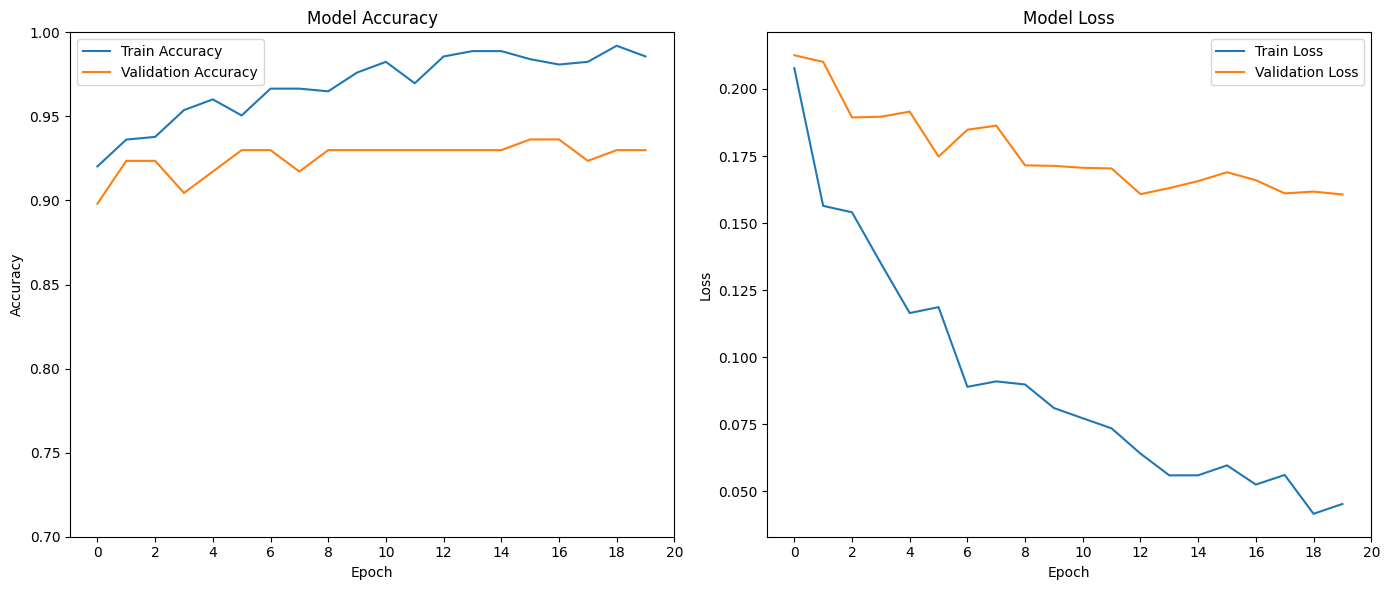

In [ ]:
# Plot training history with clearer scaling
plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1.0)  # Set y-axis from 0.7 to 1
plt.xticks(range(0, EPOCHS + 1, 2))  # Even x-axis ticks
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(0, EPOCHS + 1, 2))  # Even x-axis ticks
plt.legend()

plt.tight_layout()
plt.show()


# Evaluation

In [ ]:
def evaluate_model(model, X_val, y_val):
    """Evaluate model on validation set and print detailed metrics."""
    y_pred = model.predict(X_val, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    unique_classes = np.unique(np.concatenate([y_true_classes, y_pred_classes]))
    target_names = [CLASS_NAMES[i] for i in unique_classes]

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true_classes, y_pred_classes, average='weighted', labels=unique_classes, zero_division=0)

    print(classification_report(
        y_true_classes, y_pred_classes, labels=unique_classes, target_names=target_names, zero_division=0))

    accuracy = np.mean(y_pred_classes == y_true_classes)
    print(f"Overall Accuracy:       {accuracy:.4f}")
    print(f"Weighted Precision:     {precision:.4f}")
    print(f"Weighted Recall:        {recall:.4f}")
    print(f"Weighted F1 Score:      {f1:.4f}")

    return accuracy, precision, recall, f1

# Evaluate the model on the validation set
accuracy, precision, recall, f1 = evaluate_model(model, X_val, y_val)

              precision    recall  f1-score   support

   Unhealthy       0.94      0.97      0.95        98
    Moderate       0.90      0.84      0.87        45
     Healthy       0.93      0.93      0.93        14

    accuracy                           0.93       157
   macro avg       0.92      0.91      0.92       157
weighted avg       0.93      0.93      0.93       157

Overall Accuracy:       0.9299
Weighted Precision:     0.9293
Weighted Recall:        0.9299
Weighted F1 Score:      0.9292


# Confusion Matrix

# Test

In [ ]:
# Load Test Data
test_folder = '/content/drive/MyDrive/Sprints Final Project/Dataset Split/Test Dataset 1'
test_chunks = load_and_validate_ndvi(test_folder)
X_test_processed, y_test_processed = prepare_test_data(test_chunks)
print(f"Loaded and processed {len(X_test_processed)} test NDVI arrays")

Loaded and processed 546 test NDVI arrays


In [ ]:
from tensorflow.keras.models import load_model # Import load_model from tensorflow.keras.models
# Load the Trained Model
# Ensure that custom_objects includes NaNHandler
model = load_model(
    '/content/drive/MyDrive/Last_sprints_graduation_project/best_model_test_6.keras',
    custom_objects={'NaNHandler': tf.keras.layers.Layer}
)
print("Model loaded successfully.")

Model loaded successfully.


In [ ]:
# Generate and Display Predictions
def show_predictions(model, X_test, y_test, class_names, num_samples=9):
    """
    Display a grid of sample predictions.
    The first channel is used for visualization. The image values are displayed with the same NDVI color scale.
    """
    # Obtain model predictions
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Create subplots for sample predictions
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        idx = np.random.randint(0, len(X_test))
        # Use the first channel for display
        img = X_test[idx][..., 0]

        plt.subplot(3, 3, i+1)
        plt.imshow(img, cmap='RdYlGn', vmin=-1, vmax=1)
        plt.title(f"True: {class_names[y_true_classes[idx]]}\nPred: {class_names[y_pred_classes[idx]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

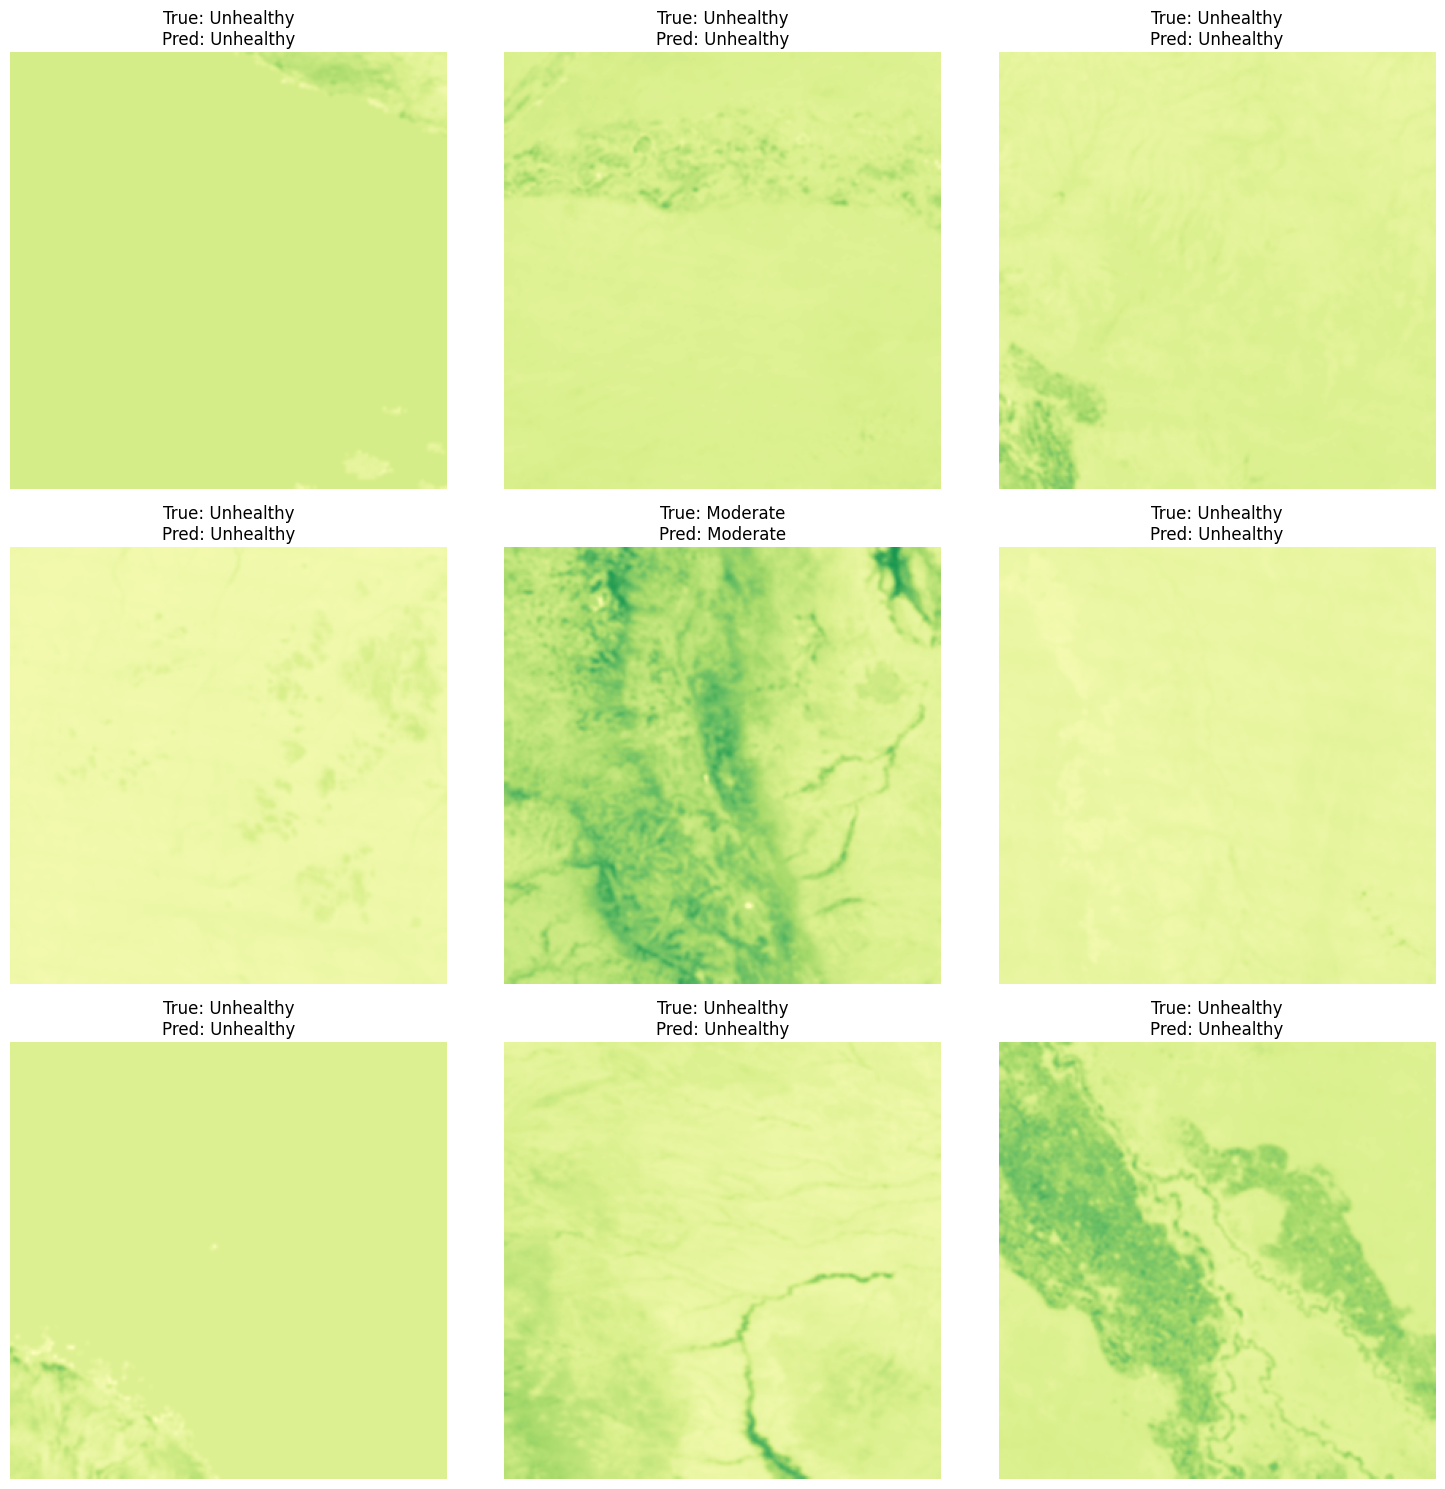

In [ ]:
# Display predictions on test data
show_predictions(model, X_test_processed, y_test_processed, CLASS_NAMES)